In [1]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="4GB")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51586,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:51598,Total threads: 2
Dashboard: http://127.0.0.1:51601/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:51589,


2025-04-01 01:32:35,171 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ce956648ece0be78741b01ddee7d62 initialized by task ('hash-join-transfer-51ce956648ece0be78741b01ddee7d62', 99) executed on worker tcp://127.0.0.1:51598
2025-04-01 01:32:47,641 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 57031ad9f3df0346629828d6802705ae initialized by task ('hash-join-transfer-57031ad9f3df0346629828d6802705ae', 9) executed on worker tcp://127.0.0.1:51597
2025-04-01 01:32:59,521 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 57031ad9f3df0346629828d6802705ae deactivated due to stimulus 'task-finished-1743456779.5175147'
2025-04-01 01:32:59,522 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ce956648ece0be78741b01ddee7d62 deactivated due to stimulus 'task-finished-1743456779.5175147'
2025-04-01 01:33:14,319 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6193c28dcbfbb021ca53480c9aa54bd7 initialized by task ('shuffle-transfer-6193c28dc

In [5]:
ms_file = 'ms_new.csv'
ms_attrs_file = 'new_ms_attr.csv'
ms_attrs_definitions = 'meta_sessions_attributes_definitions.csv'

In [6]:
import dask.dataframe as dd
import pandas as pd

In [7]:
ms = dd.read_csv(ms_file)
ms_attrs = dd.read_csv(ms_attrs_file)

In [8]:
with open(ms_attrs_definitions, 'r') as file:
    attrs_indexes = [int(line.split(',')[0].strip('"')) for i, line in enumerate(file) if i > 0]
print(*attrs_indexes, sep=', ')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28


In [9]:
for idx in attrs_indexes:
    ms_attrs[f'attr_{idx}'] = ms_attrs['value'].where(ms_attrs['session_attribute_definition_id'] == idx, 0)

In [10]:
ms_attrs = ms_attrs.drop(columns=['created_at', 'updated_at', 'session_attribute_definition_id', 'value', 'id'])

In [11]:
full_table = (
    ms_attrs
    .repartition(partition_size='10Mb')
    .merge(
        ms[['id', 'oauth_user_games_id']].repartition(partition_size='10Mb'),
        left_on='session_id',
        right_on='id',
        on='left'
    )
    .drop_duplicates(['session_id'])
)

In [ ]:
full_table.to_csv('result_data.csv', single_file=True, index=False)

In [13]:
full_table = dd.read_csv('result_data.csv')

In [14]:
def shift_group(df):
    df = df.sort_values(by='session_id')
    df['metric'] = df['attr_26'].shift(-1)
    return df

In [15]:
full_table = full_table.groupby('oauth_user_games_id').apply(shift_group, meta={**full_table.dtypes.to_dict(), 'metric': 'int64'})

In [16]:
full_table = full_table.persist()

In [ ]:
full_table.dropna(subset=['metric']).reset_index(drop=True).to_csv('prepared_data.csv', single_file=True, index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.utils import class_weight

In [19]:
full_table = pd.read_csv('prepared_data.csv')

In [20]:
attr_params = [x for x in full_table.columns if x.startswith('attr_')]

In [21]:

X_df = full_table[attr_params]
Y_df = full_table[['metric']]

In [22]:
Y_df.loc[:,'metric'] = (Y_df['metric'] > 0).astype(int)

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X_df)
Y = Y_df.values

In [ ]:
_y = Y.ravel()
correlations = np.array([np.corrcoef(X[:, i], _y)[0, 1] for i in range(X.shape[1])])

print(correlations)  # Вывод корреляций для всех 28 столбцов

In [45]:
model = Sequential([
    Input((X.shape[1],)),
    Dense(64, activation='tanh'),
    Dropout(.2),
    Dense(32, activation='tanh'),
    Dropout(.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [50]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y),
    y=y_train.ravel()
)

In [51]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=25,
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6170 - loss: 0.6919 - val_accuracy: 0.7133 - val_loss: 0.6791
Epoch 2/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.6189 - loss: 0.6884 - val_accuracy: 0.6014 - val_loss: 0.6933
Epoch 3/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6237 - loss: 0.6870 - val_accuracy: 0.5110 - val_loss: 0.7079
Epoch 4/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.5990 - loss: 0.6886 - val_accuracy: 0.6225 - val_loss: 0.6896
Epoch 5/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6107 - loss: 0.6884 - val_accuracy: 0.5982 - val_loss: 0.6857
Epoch 6/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6050 - loss: 0.6905 - val_accuracy: 0.6204 - val_loss: 0.6804
Epoch 7/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6126 - loss: 0.6872 - val_accuracy: 0.6338 - val_loss: 0.6871
Epoch 8/25
16415/16415 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from matplotlib import pyplot as plt

4104/4104 ━━━━━━━━━━━━━━━━━━━━ 4s 861us/step - accuracy: 0.5408 - loss: 0.7015
Test Accuracy: 0.5438
4104/4104 ━━━━━━━━━━━━━━━━━━━━ 2s 504us/step


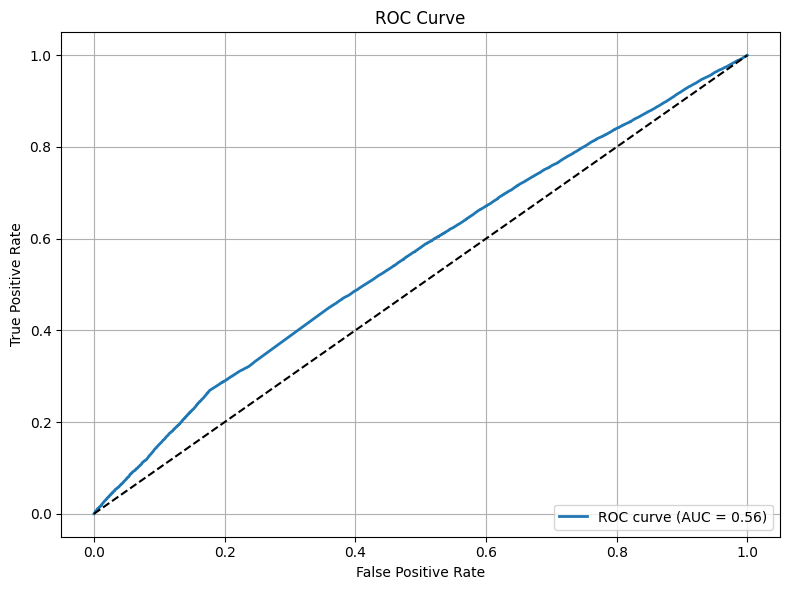

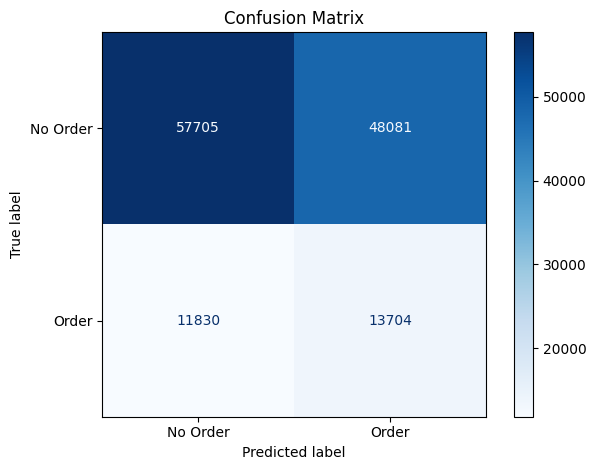

In [53]:
# === 9. Vyhodnotenie modelu ===
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# === 10. Predikcie pravdepodobností pre testovaciu množinu ===
y_probs = model.predict(x_test).ravel()  # .ravel() pre 1D vektor
y_pred = (y_probs > 0.5).astype(int)     # Binarizácia

# === 11. ROC krivka ===
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonála (náhodný model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 12. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Order", "Order"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

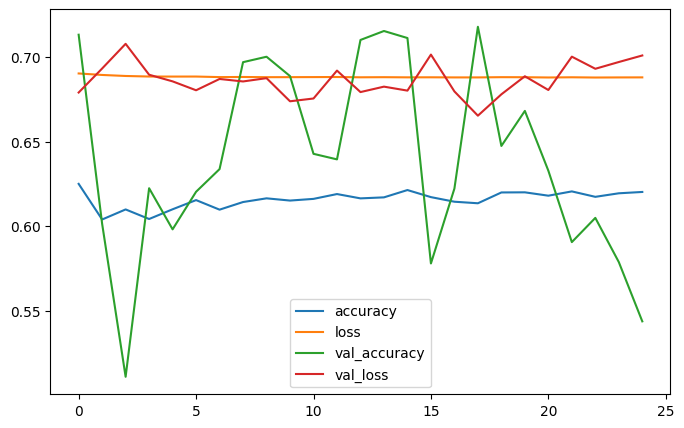

In [54]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [55]:
model.save_weights('./model2.weights.h5')